In [6]:
import numpy as np
import rasterio
from sklearn.decomposition import IncrementalPCA
from rasterio.windows import Window
import plotly.express as px
from pathlib import Path
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

In [7]:
pre_path = "../optical_high_res/pre_satellite.tiff"   # pre-event RGB image
post_path = "../optical_high_res/post_satellite.tiff"  # post-event RGB image

In [8]:
with rasterio.open(pre_path) as src_pre, rasterio.open(post_path) as src_post:
    assert src_pre.width == src_post.width
    assert src_pre.height == src_post.height
    assert src_pre.count >= 4 and src_post.count >= 4, "Need 4 bands (B,G,R,NIR)"
    
    width = src_pre.width
    height = src_pre.height
    profile = src_pre.profile

print("Image size:", width, "x", height)
num_bands_total = 8

Image size: 15560 x 19196


In [9]:
n_components = 3
ipca = IncrementalPCA(n_components=n_components)

# A block size that fits in RAM
block_size = 512  #512 or 1024

In [10]:
print("Pass 1: fitting IncrementalPCA on blocks...")

ndvi_thresh = 0.3  # NDVI threshold for vegetation vs urban
eps = 1e-6

with rasterio.open(pre_path) as src_pre, rasterio.open(post_path) as src_post:
    for row in range(0, height, block_size):
        for col in range(0, width, block_size):
            h = min(block_size, height - row)
            w = min(block_size, width - col)
            win = Window(col, row, w, h)

            # Read 4 bands from each (B,G,R,NIR) as float32
            pre_block = src_pre.read([1, 2, 3, 4], window=win).astype(np.float32)
            post_block = src_post.read([1, 2, 3, 4], window=win).astype(np.float32)

            # Stack: (8, h, w)  = [pre_B,pre_G,pre_R,pre_NIR, post_B,post_G,post_R,post_NIR]
            stack_block = np.concatenate([pre_block, post_block], axis=0)
            nb, bh, bw = stack_block.shape  # nb should be 8

            # --- NDVI-based vegetation / urban mask ---
            pre_red  = pre_block[2]  # band index 2 = Red
            pre_nir  = pre_block[3]  # band index 3 = NIR
            post_red = post_block[2]
            post_nir = post_block[3]

            ndvi_pre  = (pre_nir  - pre_red)  / (pre_nir  + pre_red  + eps)
            ndvi_post = (post_nir - post_red) / (post_nir + post_red + eps)

            # veg = NDVI above threshold in either pre or post
            veg_block   = (ndvi_pre > ndvi_thresh) | (ndvi_post > ndvi_thresh)
            urban_block = ~veg_block               # True where we treat as "urban"
            urban_flat  = urban_block.reshape(-1)  # (pixels_in_block,)

            # --- Build feature matrix X_block for this tile ---
            X_block = stack_block.reshape(nb, -1).T  # (pixels_in_block, 8)

            # Optionally skip blocks with all zeros/nodata
            if X_block.size == 0 or np.all(X_block == 0):
                continue

            # Keep only urban pixels for PCA fitting
            X_urban = X_block[urban_flat]

            if X_urban.size == 0:
                # This block is entirely vegetation → nothing useful for urban change
                continue

            # Incremental fit on this block (urban pixels only)
            ipca.partial_fit(X_urban)

print("PCA components learned.")


Pass 1: fitting IncrementalPCA on blocks...


c:\Users\dt536\Documents\IIB_project\.venv\Lib\site-packages\sklearn\decomposition\_incremental_pca.py:365: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio = S**2 / np.sum(col_var * n_total_samples)


PCA components learned.


In [11]:
# PCA component image + one change mask output

pc_profile = profile.copy()
pc_profile.update(dtype=rasterio.float32, count=1, nodata=None)

mask_profile = profile.copy()
mask_profile.update(dtype=rasterio.uint8, count=1, nodata=0)

pc_component_path = "pca_component.tif"
change_mask_path = "change_mask.tif"
# Choose which PCA component emphasises change 
pc_index = 1 #component 2

In [12]:
print("Pass 2: applying PCA and writing outputs...")

with rasterio.open(pre_path) as src_pre, rasterio.open(post_path) as src_post, \
     rasterio.open(pc_component_path, "w", **pc_profile) as dst_pc, \
     rasterio.open(change_mask_path, "w", **mask_profile) as dst_mask:

    # --------- FIRST LOOP: estimate global mean/std on chosen component (non-veg only) ---------
    comp_values = []
    ndvi_thresh = 0.3  # vegetation threshold, adjust if needed
    eps = 1e-6

    for row in range(0, height, block_size):
        for col in range(0, width, block_size):
            h = min(block_size, height - row)
            w = min(block_size, width - col)
            win = Window(col, row, w, h)

            pre_block = src_pre.read([1, 2, 3, 4], window=win).astype(np.float32)   # (4, h, w)
            post_block = src_post.read([1, 2, 3, 4], window=win).astype(np.float32)  # (4, h, w)

            # --- NDVI-based vegetation mask for this block ---
            pre_red  = pre_block[2]  # band 3 = Red
            pre_nir  = pre_block[3]  # band 4 = NIR
            post_red = post_block[2]
            post_nir = post_block[3]

            ndvi_pre  = (pre_nir  - pre_red)  / (pre_nir  + pre_red  + eps)
            ndvi_post = (post_nir - post_red) / (post_nir + post_red + eps)

            veg_block = (ndvi_pre > ndvi_thresh) | (ndvi_post > ndvi_thresh)  # (h, w)
            veg_flat = veg_block.reshape(-1)                                  # (N,)

            # --- Build X_block (all pixels) ---
            stack_block = np.concatenate([pre_block, post_block], axis=0)     # (8, h, w)
            nb, bh, bw = stack_block.shape
            X_block = stack_block.reshape(nb, -1).T                           # (N, 8)

            if X_block.size == 0 or np.all(X_block == 0):
                continue

            # --- Keep only non-vegetation pixels for stats/PCA ---
            urban_idx = ~veg_flat
            X_nv = X_block[urban_idx]
            if X_nv.size == 0:
                continue  # block is all vegetation

            X_pca_block = ipca.transform(X_nv)               # (N_urban, n_components)
            pc_block = X_pca_block[:, pc_index]              # 1D
            comp_values.append(pc_block)

    # Concatenate sample and get global mean/std (non-veg only)
    all_vals = np.concatenate(comp_values)
    global_mean = all_vals.mean()
    global_std = all_vals.std()
    del comp_values, all_vals  # free memory

    print("Estimated global mean/std for component:",
          float(global_mean), float(global_std))

    # --------- SECOND LOOP: transform & write outputs (with veg masked out) ---------
    threshold = 2.0  # z-score threshold

    for row in range(0, height, block_size):
        for col in range(0, width, block_size):
            h = min(block_size, height - row)
            w = min(block_size, width - col)
            win = Window(col, row, w, h)

            pre_block = src_pre.read([1, 2, 3, 4], window=win).astype(np.float32)
            post_block = src_post.read([1, 2, 3, 4], window=win).astype(np.float32)

            # --- NDVI-based vegetation mask ---
            pre_red  = pre_block[2]
            pre_nir  = pre_block[3]
            post_red = post_block[2]
            post_nir = post_block[3]

            ndvi_pre  = (pre_nir  - pre_red)  / (pre_nir  + pre_red  + eps)
            ndvi_post = (post_nir - post_red) / (post_nir + post_red + eps)

            veg_block = (ndvi_pre > ndvi_thresh) | (ndvi_post > ndvi_thresh)  # (h, w)
            veg_flat = veg_block.reshape(-1)                                  # (N,)

            # --- Build X_block (all pixels) ---
            stack_block = np.concatenate([pre_block, post_block], axis=0)
            nb, bh, bw = stack_block.shape
            X_block = stack_block.reshape(nb, -1).T                           # (N, 8)

            if X_block.size == 0 or np.all(X_block == 0):
                # all nodata → write zeros
                pc_img_block = np.zeros((h, w), dtype=np.float32)
                mask_block = np.zeros((h, w), dtype=np.uint8)
            else:
                urban_idx = ~veg_flat
                X_nv = X_block[urban_idx]

                if X_nv.size == 0:
                    # all vegetation → no change signal here
                    pc_img_block = np.zeros((h, w), dtype=np.float32)
                    mask_block = np.zeros((h, w), dtype=np.uint8)
                else:
                    # Transform non-veg pixels
                    X_pca_block = ipca.transform(X_nv)           # (N_urban, n_components)
                    pc_vals = X_pca_block[:, pc_index]

                    # Build full PCA component image block (zeros on veg)
                    pc_full_flat = np.zeros(veg_flat.shape, dtype=np.float32)
                    pc_full_flat[urban_idx] = pc_vals
                    pc_img_block = pc_full_flat.reshape(h, w)

                    # Normalise to z-score using global stats
                    pc_norm_block = (pc_img_block - global_mean) / (global_std + 1e-6)

                    # Threshold: |z| > threshold -> change
                    mask_block = (np.abs(pc_norm_block) > threshold).astype(np.uint8)

                    # Force vegetation to 0 in mask
                    mask_block[veg_block] = 0

            # Write this window to the output rasters
            dst_pc.write(pc_img_block.astype(np.float32), 1, window=win)
            dst_mask.write(mask_block, 1, window=win)

print("Done. Wrote", pc_component_path, "and", change_mask_path)


Pass 2: applying PCA and writing outputs...
Estimated global mean/std for component: 2.1498783897509848e-14 32.43129561353402
Done. Wrote pca_component.tif and change_mask.tif


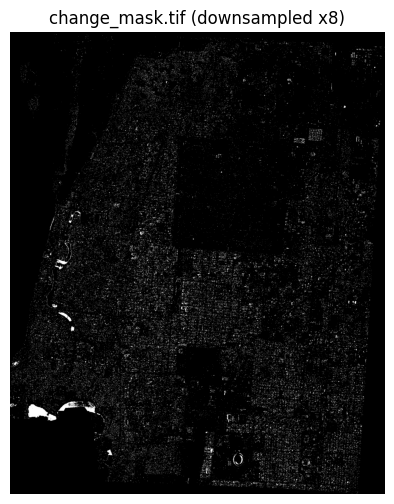

In [13]:
path = "change_mask.tif"
scale = 8  # bigger number = more downsample

with rasterio.open(path) as src:
    mask_ds = src.read(
        1,
        out_shape=(
            src.height // scale,
            src.width // scale,
        ),
        resampling=Resampling.nearest  # keep classes; use average/bilinear for continuous
    )

plt.figure(figsize=(8, 6))
plt.imshow(mask_ds, cmap="gray")
plt.axis("off")
plt.title(f"{path} (downsampled x{scale})")
plt.show()